In [2]:
import warnings
warnings.simplefilter('ignore')

#import dill
import numpy as np
import pandas as pd
import requests
#import shap

# from lightfm import LightFM
# from lightfm.data import Dataset
# from lightgbm import LGBMRanker, LGBMClassifier
from rectools.metrics import calc_metrics, NDCG, MAP, Precision, Recall, MeanInvUserFreq
from rectools import Columns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from typing import Any, Dict, Tuple
from tqdm.auto import tqdm
from zipfile import ZipFile

from tools import generate_lightfm_recs_mapper, avg_user_metric

In [3]:
interactions = pd.read_csv("../data/interactions.csv")
items = pd.read_csv("../data/items.csv")
users = pd.read_csv("../data/users.csv")

In [4]:
# Меняем названия колонок для использования rectools
interactions.rename(
    columns={
        'last_watch_dt': Columns.Datetime,
        'watched_pct': Columns.Weight,
    }, 
    inplace=True,
) 
# Меняем тип данных
interactions['datetime'] = interactions['datetime'].astype(np.datetime64)

# Заполняем пропуски
interactions_default_values: Dict[str, Any] = {
   Columns.Datetime: interactions[Columns.Datetime].median(),
    Columns.Weight: 0.,
    'total_dur': 0,
}
interactions.fillna(interactions_default_values, inplace=True)

# Смотрим что получилось
interactions.head(10)

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5,1032142,6686,2021-05-13,11286,100.0
6,1016458,354,2021-08-14,1672,25.0
7,884009,693,2021-08-04,703,14.0
8,648682,1449,2021-06-13,26246,75.0
9,203219,13582,2021-08-22,6975,100.0


In [5]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {}  # словарь с категориями

    # Тут мы могли бы заполнять пропуски как еще одну категорию,
    # но они и так заполняются таким образом автоматически ниже
    # default_values = {col: 'None' for col in cat_cols}
    # df.fillna(default_values, inplace=True)

    for col in cat_cols:
        cat_col = df[col].astype('category').cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype('category')
    return df, cat_col_encoding

users_cat_cols = [
    # 'user_id',
     'age', 'income', 'sex', 'kids_flg'
]
users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)

# None уже кодируется как -1
users_cat_col_encoding['income'], users['income'].unique()

(Index(['income_0_20', 'income_150_inf', 'income_20_40', 'income_40_60',
        'income_60_90', 'income_90_150'],
       dtype='object'),
 [4, 2, 3, 0, -1, 5, 1]
 Categories (7, int64): [-1, 0, 1, 2, 3, 4, 5])

In [6]:
# Аналогичным образом кодируем категориальные колонки и пока удаляем текстовые
items_cat_cols = [
    # 'item_id', 
    'content_type', 'for_kids', 'studios',
]
items_text_cols = [
    'title', 'title_orig', 'genres', 'countries', 'directors', 'actors', 'description', 'keywords',
]
items_num_cols = [
    'release_year', 'age_rating', 
]
default_values_items = {
    'release_year': items['release_year'].median(),
    'age_rating': items['age_rating'].median(),
}

items, items_cat_col_encoding = encode_cat_cols(items, items_cat_cols) 
items = items.drop(items_text_cols, axis=1)
items.fillna(default_values_items, inplace=True)

items_cat_col_encoding['studios']

Index(['ABC', 'Amediateka', 'BBC', 'CBS', 'CBS All Access', 'Channel 4',
       'Cinemax', 'DAZN', 'Disney', 'Endemol', 'FX', 'Fox', 'Fremantle', 'HBO',
       'HBO Max', 'HBO, BBC', 'Legendary', 'MGM', 'New Regency Productions',
       'Paramount', 'Showtime', 'Sky', 'Sky, Fremantle', 'Sony Pictures',
       'Sony Pictures Television', 'Sony Pictures, рентв', 'Sony Plus',
       'Sony Plus, рентв', 'Starz', 'Universal', 'Universal, рентв',
       'Warner Bros', 'Warner Bros. Television', 'Ленфильм', 'Ленфильм, рентв',
       'Мосфильм', 'Рок фильм', 'рентв'],
      dtype='object')

# Split Data

In [7]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f'min дата в interactions: {min_date}')
print(f'max дата в interactions: {max_date}')
print(f'Продолжительность: {max_date - min_date}')

min дата в interactions: 2021-03-13 00:00:00
max дата в interactions: 2021-08-22 00:00:00
Продолжительность: 162 days 00:00:00


In [8]:
# Обучать ранжирование будем на последнем месяце (30 дней) не считая отложенной недели
# Лучше зафиксировать временной диапазон если на проде планируется переобучать модель
ranker_days_count = 30

ranker_data = interactions[
    (interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=ranker_days_count))
]

# В дальнейшем ranker_data разбиваем по юзерам 
#  на train val test для обучения, валидации и тестирования ранкера
train_size = 0.7
val_size = 0.15
test_size = 0.15

# В train_test_split очень удобно можно сохранить исходное распределение по нужным факторам,
#  задав параметр stratify. Правда мы на это пока забьем)  

train_val_users, test_users = train_test_split(
    ranker_data['user_id'].unique(), random_state=42, test_size=test_size
)

train_users, val_users = train_test_split(
    train_val_users, random_state=42, test_size=val_size / (train_size + val_size)  # 15% от общего размера
)

In [9]:
# Для базовых моделей первого уровня (в нашем случае только lightfm) 
#  оставим все оставшиеся взаимодействия для обучения

base_models_data = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))
]

# Обучаем модель первого уровня

Давайте представим, что на текущий момент у нас есть готовая модель (или даже несколько) в проде и надо улучшить качество, переранжировав рекомендации этих моделей. Кажется, что можно взять их и на их предсказаниях обучить ранкер.

Это неплохое решение, потому что при реранжировании нужно опираться на качественные скоры и ранги. Но это не вся проблема - на деле еще нужно сделать так, чтобы как можно больше хороших айтемов было предсказано на первом уровне. Т.е. на первом уровне должна быть хотя бы одна модель, которая максимизирует recall, чтобы на вход ранкеру гарантированно попадали все потенциально хорошие айтемы.

In [15]:
# В рамках семинара мы не будем обучать большое количество моделей первого уровня и
# ограничимся только LightFM
lightfm_dataset = Dataset()
lightfm_user_ids = base_models_data['user_id'].unique()
lightfm_item_ids = base_models_data['item_id'].unique()
lightfm_dataset.fit(lightfm_user_ids, lightfm_item_ids)

In [16]:
# В качестве таргета можно придумать что-то сложное на основе имеющихся
# процента досмотра или абсолютного значения просмотра.
# Как один из вариантов - возьмем процент досмотра - watched_pct (Columns.Weight).

# Тогда матрицу интеракций и весов можно получить следующим образом:
interactions_matrix, weights_matrix = lightfm_dataset.build_interactions(
    zip(*base_models_data[['user_id', 'item_id', Columns.Weight]].values.T)
)
weights_matrix = weights_matrix.tocsr()

In [17]:
# Обучаем модель
# Не используем доступные фичи юзеров и айтемов, оставим это на этап реранжирования

lfm_model = LightFM(
    no_components=64, 
    learning_rate=0.01, 
    loss='warp', 
    max_sampled=5, 
    random_state=42,
)

num_epochs = 3

for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(weights_matrix)

100%|██████████| 3/3 [00:29<00:00,  9.90s/it]


### Генерим кандидатов, которыми дополним датасет ранкера

In [18]:
# Маппинги обычных айдишников во внутренние индексы lightfm для юзеров и айтемов
lightfm_mapping = lightfm_dataset.mapping()
lightfm_mapping = {
    'user_id_to_iid': lightfm_mapping[0],  # iid - internal lfm id
    'item_id_to_iid': lightfm_mapping[2],
}
# Маппинги внутренние индексов lightfm в обычные айдишники для юзеров и айтемов
lightfm_mapping['user_iid_to_id'] = {v: k for k, v in lightfm_mapping['user_id_to_iid'].items()}
lightfm_mapping['item_iid_to_id'] = {v: k for k, v in lightfm_mapping['item_id_to_iid'].items()}

In [21]:
# Топ 100 кандидатов 
# Как понять сколько их нужно?
top_N = 100

# Внутренние индексы юзеров и айтемов lightfm (индексы матрицы user-item)
user_lfm_index = np.array(list(lightfm_mapping['user_id_to_iid'].values()))
item_lfm_index = np.array(list(lightfm_mapping['item_id_to_iid'].values()))

# Делаем предикт, ограничиваем его сверху top_N 
# и сразу переводим в настоящие айдишники
mapper = generate_lightfm_recs_mapper(
    model=lfm_model, 
    N=top_N,
    item_iids=item_lfm_index, 
    user_id_to_iid=lightfm_mapping['user_id_to_iid'],
    item_iid_to_id=lightfm_mapping['item_iid_to_id'],
    known_item_ids=dict(),  # тут можно добавить уже просмотренный контент для его исключения
    num_threads=24,
)

In [22]:
# Генерируем предсказания и получаем скоры и ранги lightfm

candidates = pd.DataFrame({'user_id': lightfm_user_ids})
candidates['item_id'], candidates['lfm_score'] = zip(*candidates['user_id'].map(mapper))
candidates = candidates.explode(['item_id', 'lfm_score'], ignore_index=True)
candidates['lfm_rank'] = candidates.groupby('user_id').cumcount() + 1 

# Делаем чекпоинт - сохраняем кандидатов
# candidates.to_csv('data/candidates.csv', index=False)

candidates.head(3)

: 

: 

In [ ]:
candidates.to_csv('../data/candidates.csv', index=False)

In [15]:
# Считаем метрики
def calc_metrics_(candidates_df, rank_col: str) -> Dict[str, float]:
    metrics = {
        'ndcg@10': NDCG(k = 10),
        'map@10': MAP(k = 10),
        'Precision@10': Precision(k = 10),
        'recall@10': Recall(k = 10),
        'recall@100': Recall(k = 100),
        'novelty@10': MeanInvUserFreq(k = 10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df
            .rename(columns={rank_col: Columns.Rank})
            [[Columns.User, Columns.Item, Columns.Rank]]
            [candidates_df[Columns.User].isin(test_users)]
        ),
        interactions=(
            ranker_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [ranker_data[Columns.User].isin(test_users)]
        ), 
        prev_interactions=(
            base_models_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [base_models_data[Columns.User].isin(test_users)]
        ),
        catalog=items['item_id'].unique()
    )

models_metrics: Dict[str, Dict[str, float]] = dict()
models_metrics['lfm'] = calc_metrics_(candidates, 'lfm_rank')
models_metrics['lfm']

{'Precision@10': 0.023805503967583994,
 'recall@10': 0.07967891916043812,
 'recall@100': 0.16289180457612906,
 'ndcg@10': 0.028135831933700922,
 'map@10': 0.03586135879485816,
 'novelty@10': 2.918728031203174}

{'Precision@10': 0.023805503967583994,  
 'recall@10': 0.07967891916043812,  
 'recall@100': 0.16289180457612906,  
 'ndcg@10': 0.028135831933700922,  
 'map@10': 0.03586135879485816,  
 'novelty@10': 2.918728031203174}  

### Формируем датасет для ранкера

In [10]:
# Получаем длину истории юзера 
base_models_data['user_hist'] = (
    base_models_data.groupby('user_id')
    ['item_id'].transform('count')
)
# Получаем популярность контента
base_models_data['item_pop'] = (
    base_models_data.groupby('item_id')
    ['user_id'].transform('count')
)
# Получаем среднюю популярность контента, просматриваемого этим юзером
base_models_data['user_avg_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('mean')
)
# Получаем среднюю длину истории пользователя, которые смотрит этот контент
base_models_data['item_avg_hist'] = (
    base_models_data.groupby('item_id')
    ['user_hist'].transform('mean')
)
# Получаем популярность последнего просмотренного контента
base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime], 
    ascending=[True, False], 
    ignore_index=True,
    inplace=True,
)
base_models_data['user_last_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('first')
)
base_models_data.head(3)

,user_id,item_id,datetime,total_dur,weight,user_hist,item_pop,user_avg_pop,item_avg_hist,user_last_pop
0,0,6006,2021-07-20,1,0.0,6,5208,41885.0,16.891897,5208
1,0,7102,2021-07-19,169,3.0,6,11626,41885.0,20.349475,5208
2,0,14359,2021-07-19,130,2.0,6,6053,41885.0,22.546836,5208


In [ ]:
dates =  base_models_data['datetime']

features_dfs = []
for curr_date in dates:
    dfs = []
    for window in [30, 4, 2, 1]:
        start_date = curr_date - window
        period_df = base_models_data[(base_models_data.datetime >= start_date) &(base_models_data.datetime <= curr_date)]
        group_period_df = period_df.groupby(["user","item"], as_index=False).sum()
        # print(group_period_df)
        dfs.append(group_period_df)
    features_df = dfs[0]
    
    for _df in dfs[1:]:
        features_df = features_df.merge(_df, how="left", on=["user", "item"])
    features_df["ds"] = curr_date
    features_dfs.append(features_df)

base_models_data = pd.concat(features_dfs)

In [11]:
# Добавляем новые фичи в соответствующие таблички
items = pd.merge(
    left=items, 
    right=(
        base_models_data
        [['item_id', 'item_pop', 'item_avg_hist']]
        .drop_duplicates()
    ),
    how='left',
    on='item_id',
)

users = pd.merge(
    left=users, 
    right=(
        base_models_data
        [['user_id', 'user_hist', 'user_avg_pop', 'user_last_pop']]
        .drop_duplicates()
    ),
    how='left',
    on='user_id',
)
users.head(3)

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop
0,973171,1,4,1,1,5.0,19550.800000,93403.0
1,962099,0,2,1,0,13.0,1329.307692,260.0
2,1047345,3,3,0,0,NaN,NaN,NaN


In [12]:
# Обновляем дефолтные значения
# Прямо сейчас обновлять таблички users и items не обязательно, 
# сделаем это при джойне с кандидатами

# Для новых фичей айтемов
default_values_items['item_pop'] = base_models_data['item_pop'].median()
default_values_items['item_avg_hist'] = base_models_data['item_avg_hist'].median()

# Для новых фичей юзеров
default_values_users = {
    'user_hist': 0,
    'user_avg_pop': base_models_data['user_avg_pop'].median(),
    'user_last_pop': base_models_data['user_last_pop'].median(),
}

In [13]:
default_values_users

{'user_hist': 0, 'user_avg_pop': 11957.864864864865, 'user_last_pop': 2858.0}

In [22]:
# Вспоминаем про наши выборки интеракций для ранкера.
# Мы отобрали юзеров для обучения, валидации и теста.
# Оставляем среди них только тех, для кого есть и рекомы и таргеты

def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame, 
    df: pd.DataFrame,
) -> pd.DataFrame:
    # Джойним интеракции на наших кандидатов для юзеров из трейна, вал и теста
    df = pd.merge(
        df[df['user_id'].isin(user_list)], 
        candidates_df[candidates_df['user_id'].isin(user_list)], 
        how='right',  # right ? 
        on=['user_id', 'item_id']
    )
    # Проставляем дефолтные значения интеракций
    min_score: float =  df['lfm_score'].min() - 0.01
    max_rank: int = df['lfm_rank'].max() + 1  # 101
    
    default_values = {
        'lfm_score': min_score, 'lfm_rank': max_rank,
        # Важно использовате те же дефолтные значения для интеракций, 
        # чтобы не сделать утечку
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)
        
    # Сортируем по user_id - это пригодится для вычисления рангов и групп для ранжирования
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    return df

ranker_train = users_filter(train_users, candidates, ranker_data)
ranker_val = users_filter(val_users, candidates, ranker_data)
ranker_test = users_filter(test_users, candidates, ranker_data)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank
11733093,3,14,2021-07-01,0.0,0.0,1.057801,94
11733088,3,24,2021-07-01,0.0,0.0,1.093266,89
11733034,3,101,2021-07-01,0.0,0.0,1.392774,35


In [24]:
# Добавляем фичи
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(
        df, 
        users, 
        how='left', 
        on=['user_id']
    )
    df = pd.merge(
        df, 
        items, 
        how='left', 
        on=['item_id']
    )

    # При джойне могут получиться строки с несуществующими айтемами или юзерами.
    # Надо заполнить пропуски. Используем заготовленные дефолтные значения,
    # чтобы не сделать утечку
    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    # Категориальные фичи закодированы пандасом так, что None === -1
    # Если изначально пропусков не было, то нужно добавить такое значение категории
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df

# Не забываем добавить фичи в трейн, вал и тест
# Еще правильнее бы было сначала подготовить датасет, 
# а потом его разбивать по юзерам - так бы мы избежали дублирования операций.
ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,age,income,sex,...,user_hist,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist
0,3,14,2021-07-01,0.0,0.0,1.057801,94,-1,-1,-1,...,0.0,11957.864865,2858.0,1,2019.0,-1,16.0,-1,5675.0,17.167225
1,3,24,2021-07-01,0.0,0.0,1.093266,89,-1,-1,-1,...,0.0,11957.864865,2858.0,1,2020.0,-1,16.0,-1,6676.0,17.415518
2,3,101,2021-07-01,0.0,0.0,1.392774,35,-1,-1,-1,...,0.0,11957.864865,2858.0,0,2019.0,-1,18.0,-1,9542.0,17.990673


In [27]:
# Датасеты готовы, остались только таргеты, 
# которые можно посчитать на основе колонок total_dur и watched_pct

# Делаем еще один чекпоинт.

# Не пользуемся методом eval если точно не знаем, что за строка.
# Он не безопасен и долго работает.
# Можно заменить на locals()[name]
for name in ['train', 'val', 'test']:
    path: str = f'data_original/ranker_{name}.csv'
    # eval(f'ranker_{name}').to_csv(path, index=False)
    locals()[f'ranker_{name}'].to_csv(path, index=False)

### Обучаем ранкер

In [28]:
# Загружаем данные
for name in ['train', 'val', 'test']:
    path: str = f'data_original/ranker_{name}.csv'
    locals()[f'ranker_{name}'] = pd.read_csv(path)

In [29]:
# таргет бинарный, так что - 
# будем считать просмотр хорошим если доля досмотра больше половины

def add_target(df: pd.DataFrame) -> pd.DataFrame:
    df['target'] = df[Columns.Weight] > 50  # 'watched_pct'
    df['target'] = df['target'].astype(int)
    return df

ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,age,income,sex,...,user_avg_pop,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target
0,3,14.0,2021-07-01,0.0,0.0,1.057801,94.0,-1,-1,-1,...,11957.864865,2858.0,1,2019.0,-1,16.0,-1,5675.0,17.167225,0
1,3,24.0,2021-07-01,0.0,0.0,1.093266,89.0,-1,-1,-1,...,11957.864865,2858.0,1,2020.0,-1,16.0,-1,6676.0,17.415518,0
2,3,47.0,2021-08-16,2179.0,27.0,0.095324,101.0,-1,-1,-1,...,11957.864865,2858.0,0,2017.0,-1,18.0,-1,1249.0,38.180144,0


In [30]:
# В train и val можно удалить 'плохих' пользователей, 
# Например тех у кого слишком много или мало просмотров или 
# тех для которых нет достаточного количества рекомендаций от LightFM
# Тестовую группу не меняем

def filter_group(df: pd.DataFrame) -> pd.DataFrame:
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    groups_df = (
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        .rename(columns={'item_id': 'group_size'})
    )
    df = pd.merge(
        df, 
        groups_df, 
        how='left', 
        on=['user_id']
    )
    # Удаляем группы, без достаточного числа просмотров/кандидатов
    df = df[df['group_size'] >= 100]

    # Колонка больше не нужна
    df.drop(columns=['group_size'], inplace=True)
    return df

ranker_train = filter_group(ranker_train)
ranker_val = filter_group(ranker_val)
# ranker_test = filter_group(ranker_test)

In [31]:
# Убираем ненужные айдишники, временные метки и таргеты.
# Для обучения используются только cols:
cols = [
    'lfm_score', 'lfm_rank', 
    'age', 'income', 'sex', 'kids_flg', 'user_hist', 'user_avg_pop', 'user_last_pop',
    'content_type', 'release_year', 'for_kids', 'age_rating', 'studios', 'item_pop', 'item_avg_hist',
]
# Из них категориальные:
cat_cols = [
    'age', 'income', 'sex', 'kids_flg',
    'content_type', 'for_kids', 'studios',
]

In [32]:
early_stopping_rounds = 32

params = {
    'objective': 'binary',
    'n_estimators': 10000,  # максимальное число деревьев
    'max_depth': 4,  # максимальная глубина дерева
    'num_leaves': 10,  # число листьев << 2^max_depth
    'min_child_samples': 100,  # число примеров в листе
    'learning_rate': 0.25,  # шаг обучения
    'reg_lambda': 1,  # L2 регуляризация
    'colsample_bytree': 0.9,  # доля колонок, которая используется в каждом дереве
    'early_stopping_rounds': early_stopping_rounds,  # число итераций, в течение которых нет улучшения метрик
    'verbose': early_stopping_rounds // 8,  # период вывода метрик
    'random_state': 42,
}
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target'],
    'eval_set': [(ranker_val[cols], ranker_val['target'])],
    'eval_metric': 'logloss',
    'categorical_feature': cat_cols,
    'feature_name': cols,
}
pointwise_model = LGBMClassifier(**params)
pointwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 250452, number of negative: 13738787
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.915532
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.254408
[LightGBM] [Debug] init for col-wise cost 0.061818 seconds, init for row-wise cost 0.520807 seconds
[Light

LGBMClassifier(colsample_bytree=0.9, early_stopping_rounds=32,
               learning_rate=0.25, max_depth=4, min_child_samples=100,
               n_estimators=10000, num_leaves=10, objective='binary',
               random_state=42, reg_lambda=1, verbose=4)

In [33]:
# Смотрим на логлосс на валидации
pointwise_model.best_score_['valid_0']['binary_logloss']

0.0876143512672293

In [34]:
# SHAP - values
explainer = shap.Explainer(pointwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

# lightGBM returns probabilities for both classes and I have to modify the SHAP values as
shap_values.values = shap_values.values[:,:,1]
shap_values.base_values = shap_values.base_values[:,1]

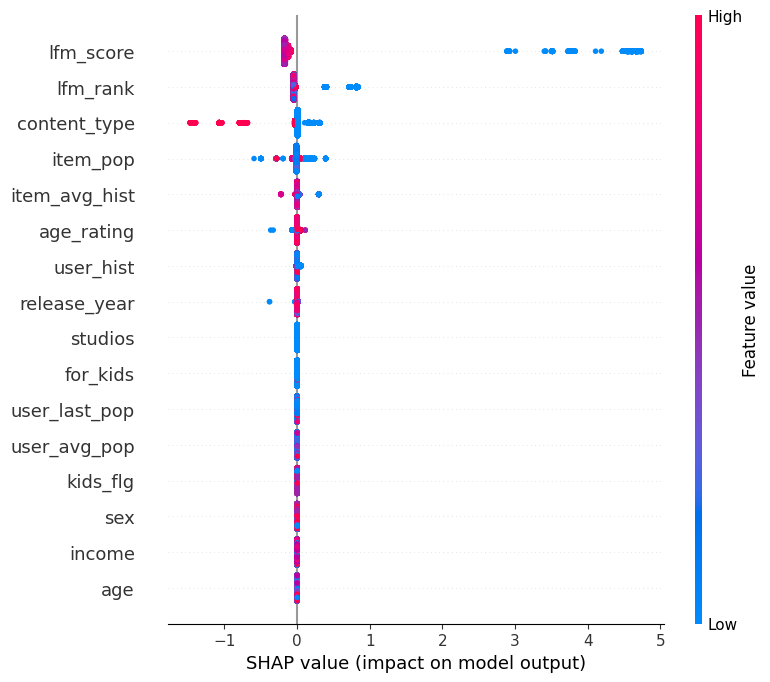

In [35]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

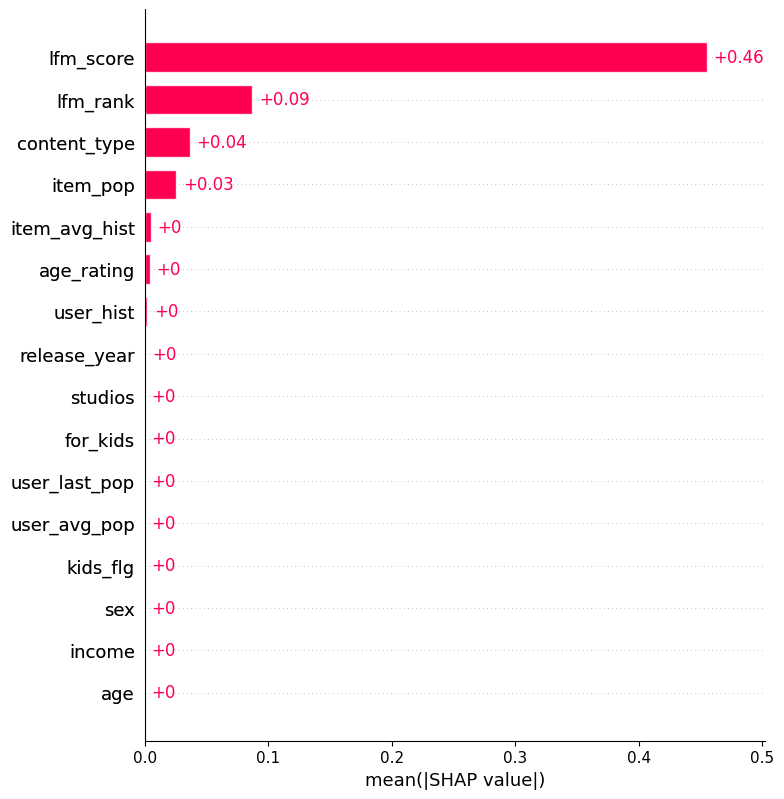

In [36]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

In [37]:
# Получаем предсказания для тестовых юзеров
y_pred: np.ndarray = pointwise_model.predict_proba(ranker_test[cols])[:, 1]
y_true: np.ndarray = np.array(ranker_test['target'])

y_pred

array([0.69561512, 0.14912251, 0.29973401, ..., 0.69561512, 0.69561512,
       0.63662944])

In [38]:
def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    # Добавляем скор модели второго уровня
    df[f'{name}_score'] = y_pred_scores
    # Добавляем ранг модели второго уровня
    df.sort_values(
        by=['user_id', f'{name}_score'],
        ascending=[True, False],
        inplace=True,
    )
    df[f'{name}_rank'] = df.groupby('user_id').cumcount() + 1

    # Исключаем айтемы, которые не были предсказаны на первом уровне
    mask = (df['lfm_rank'] < 101).to_numpy()
    # Добавляем общий скор двухэтапной модели
    eps: float = 0.001
    min_score: float = min(y_pred_scores) - eps
    df[f'{name}_hybrid_score'] = df[f'{name}_score'] * mask
    df[f'{name}_hybrid_score'].replace(
        0,
        min_score,
        inplace=True,
    )
    # Добавляем общий ранг двухэтапной модели
    df[f'{name}_hybrid_rank'] = df[f'{name}_rank'] * mask
    max_rank: int = 101
    df[f'{name}_hybrid_rank'].replace(
        0,
        max_rank,
        inplace=True,
    )
    return df

ranker_test = add_score_and_rank(ranker_test, y_pred, 'pointwise')
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,age,income,sex,...,for_kids,age_rating,studios,item_pop,item_avg_hist,target,pointwise_score,pointwise_rank,pointwise_hybrid_score,pointwise_hybrid_rank
0,1,3669.0,2021-08-16,1593.0,26.0,0.070931,101.0,1,2,0,...,-1,18.0,-1,2846.0,22.675978,0,0.695615,1,0.010878,101
1,1,10440.0,2021-08-13,19579.0,80.0,0.070931,101.0,1,2,0,...,-1,18.0,-1,141889.0,8.068716,1,0.149123,2,0.010878,101
2,12,846.0,2021-08-21,5929.0,18.0,0.070931,101.0,-1,-1,-1,...,0,16.0,-1,528.0,22.799242,0,0.299734,1,0.010878,101


In [39]:
# Считаем рок аук от sklearn (не усредненный по юзерам)
roc_auc_score(y_true, y_pred)  # Получилась ерунда

0.9318559368850203

In [40]:
# усредненный рок аук по юзерам
# df должен быть отсортирован по user_id
(
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['pointwise_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score
    ), 
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['pointwise_hybrid_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score
    )
)
# Ранкер вроде ранжирует, но вот весь пайплайн в целом - не очень

(0.7573263558600541, 0.38572980461319567)

In [41]:
# Получим значения метрик, а так же
# вспомним, какие метрики были у LightFM и сравним их между собой. Что не так?
models_metrics['pointwise'] = calc_metrics_(ranker_test, 'pointwise_rank')
models_metrics['pointwise_hybrid'] = calc_metrics_(ranker_test, 'pointwise_hybrid_rank')

pd.DataFrame(models_metrics)[['lfm', 'pointwise', 'pointwise_hybrid']]

,lfm,pointwise,pointwise_hybrid
Precision@10,0.023806,0.295435,0.016784
recall@10,0.079679,0.885487,0.071045
recall@100,0.162892,0.997895,0.160845
ndcg@10,0.028136,0.406157,0.016667
map@10,0.035861,0.842556,0.027215
novelty@10,2.918728,6.012510,2.962781


Исправляем баг в users_filter

In [42]:
# Исправляем баг, с outher join в users_filter
def filter_interations(df: pd.DataFrame) -> pd.DataFrame:
    return df[df['lfm_rank'] <= 100]

ranker_train = filter_interations(ranker_train)
ranker_val = filter_interations(ranker_val)

In [43]:
# Обучаем модель заново, на очищенных данных
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target'],
    'eval_set': [(ranker_val[cols], ranker_val['target'])],
    'eval_metric': 'logloss',
    'categorical_feature': cat_cols,
    'feature_name': cols,
}
pointwise_model = LGBMClassifier(**params)
pointwise_model.fit(**fit_params)
print(pointwise_model.best_score_['valid_0'])

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 76439, number of negative: 13444061
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.917403
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.254277
[LightGBM] [Debug] init for col-wise cost 0.091167 seconds, init for row-wise cost 0.521925 seconds
[LightG

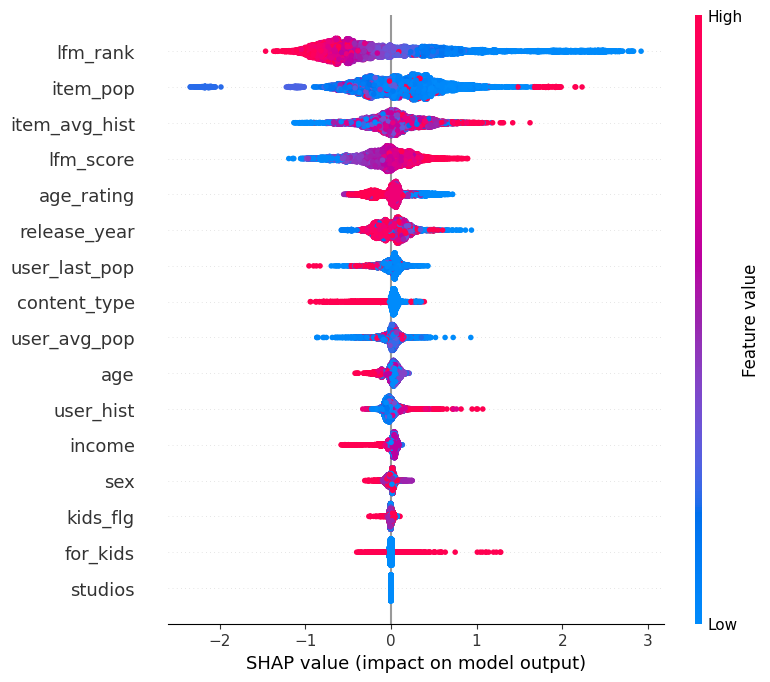

In [44]:
# Проверяем как изменилить shap-values

# SHAP - values
explainer = shap.Explainer(pointwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

# lightGBM returns probabilities for both classes and I have to modify the SHAP values as
shap_values.values = shap_values.values[:,:,1]
shap_values.base_values = shap_values.base_values[:,1]

# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

In [45]:
# Получаем предикты и смотрим на метрики
y_pred: np.ndarray = pointwise_model.predict_proba(ranker_test[cols])[:, 1]
ranker_test = add_score_and_rank(ranker_test, y_pred, 'fixed_pointwise')

models_metrics['fixed_pointwise'] = calc_metrics_(ranker_test, 'fixed_pointwise_rank')
models_metrics['fixed_pointwise_hybrid'] = calc_metrics_(ranker_test, 'fixed_pointwise_hybrid_rank')

pd.DataFrame(models_metrics)[['lfm', 'fixed_pointwise_hybrid', 'pointwise_hybrid']]

,lfm,fixed_pointwise_hybrid,pointwise_hybrid
Precision@10,0.023806,0.025769,0.016784
recall@10,0.079679,0.084406,0.071045
recall@100,0.162892,0.162613,0.160845
ndcg@10,0.028136,0.031932,0.016667
map@10,0.035861,0.042085,0.027215
novelty@10,2.918728,3.408489,2.962781


Pairwise/Listwise

In [46]:
# Для обучения ранжированию нужно правильно сформировать группы. 
# В нашем случае группа равна одному юзеру.
# Для LGBMRanker нужно задать отсортированный по юзерам (группам) датафрейм,
# для которого списком групп будет список из количества 
# ранжируемых айтемов на каждого юзера (группу).

# Официальная [дока|https://lightgbm.readthedocs.io/en/v3.3.2/pythonapi/lightgbm.LGBMRanker.html?highlight=ranker]:
# sum(group) = n_samples. 
# For example, if you have a 100-document dataset with 
# group = [10, 20, 40, 10, 10, 10], that means that you have 6 groups, 
# where the first 10 records are in the first group

# Важно! Если вы решите использовать CatBoostRanker или XGBoostRanker - там группы строятся по-другому.

def get_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        ['item_id']
    )

In [47]:
# Добавим таргет посложнее

def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df['target_ranker'] = (df[Columns.Weight] >= 15).astype(int)  # 'watched_pct'
    df['target_ranker'] += (df[Columns.Weight] >= 75).astype(int)
    return df

ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,age,income,sex,...,user_last_pop,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target,target_ranker
0,3,14.0,2021-07-01,0.0,0.0,1.057801,94.0,-1,-1,-1,...,2858.0,1,2019.0,-1,16.0,-1,5675.0,17.167225,0,0
1,3,24.0,2021-07-01,0.0,0.0,1.093266,89.0,-1,-1,-1,...,2858.0,1,2020.0,-1,16.0,-1,6676.0,17.415518,0,0
3,3,101.0,2021-07-01,0.0,0.0,1.392774,35.0,-1,-1,-1,...,2858.0,0,2019.0,-1,18.0,-1,9542.0,17.990673,0,0


In [48]:
early_stopping_rounds = 32
params = {
    'objective': 'lambdarank',  # lambdarank, оптимизирующий ndcg 
    'n_estimators': 10000,  # максимальное число деревьев
    'max_depth': 4,  # максимальная глубина дерева
    'num_leaves': 10,  # число листьев << 2^max_depth
    'min_child_samples': 100,  # число примеров в листе
    'learning_rate': 0.25,  # шаг обучения
    'reg_lambda': 1,  # L2 регуляризация
    'colsample_bytree': 0.9,  # доля колонок, которая используется в каждом дереве
    'early_stopping_rounds': early_stopping_rounds,  # число итераций, в течение которых нет улучшения метрик
    'verbose': early_stopping_rounds // 8,  # период вывода метрик
    'random_state': 42,
}
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target_ranker'],
    'group': get_group(ranker_train),
    'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
    'eval_group': [get_group(ranker_val)],
    'eval_metric': 'ndcg',
    'eval_at': (3, 5, 10),
    'categorical_feature': cat_cols,
    'feature_name': cols,
}
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.917403
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.254277
[LightGBM] [Debug] init for col-wise cost 0.096397 seconds, init for row-wise cost 0.493491 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing

LGBMRanker(colsample_bytree=0.9, early_stopping_rounds=32, learning_rate=0.25,
           max_depth=4, min_child_samples=100, n_estimators=10000,
           num_leaves=10, objective='lambdarank', random_state=42, reg_lambda=1,
           verbose=4)

In [49]:
listwise_model.best_score_['valid_0']

OrderedDict([('ndcg@3', 0.642349559790849),
             ('ndcg@5', 0.6656307495365652),
             ('ndcg@10', 0.6899443886711372)])

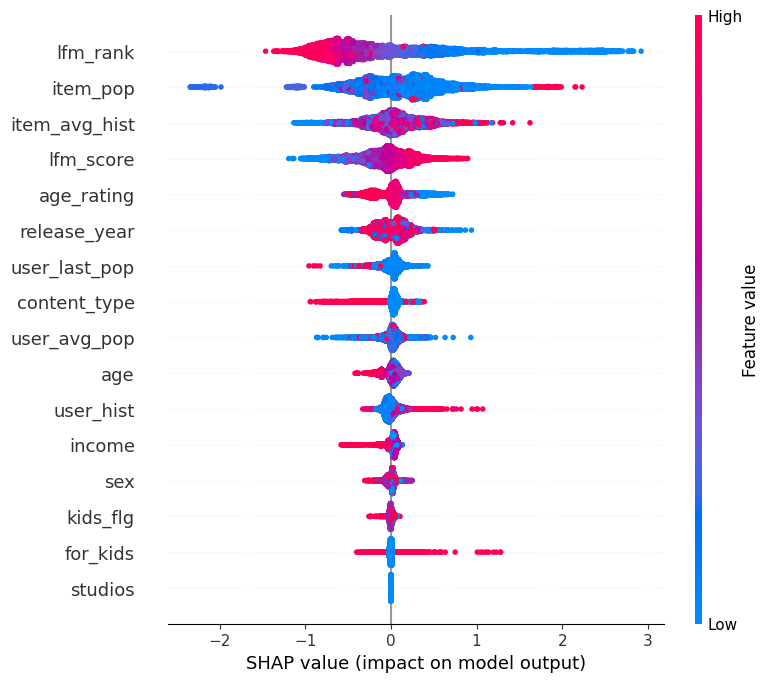

In [50]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

In [51]:
y_pred: np.ndarray = listwise_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, 'listwise')
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,age,income,sex,...,pointwise_hybrid_rank,fixed_pointwise_score,fixed_pointwise_rank,fixed_pointwise_hybrid_score,fixed_pointwise_hybrid_rank,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
1,1,10440.0,2021-08-13,19579.0,80.0,0.070931,101.0,1,2,0,...,101,0.014589,1,-0.000988,101,2,0.258351,1,-5.63861,101
0,1,3669.0,2021-08-16,1593.0,26.0,0.070931,101.0,1,2,0,...,101,0.000761,2,-0.000988,101,1,-1.809115,2,-5.63861,101
2,12,846.0,2021-08-21,5929.0,18.0,0.070931,101.0,-1,-1,-1,...,101,0.001698,1,-0.000988,101,1,-1.726663,1,-5.63861,101


In [52]:
models_metrics['listwise'] = calc_metrics_(ranker_test, 'listwise_rank')
models_metrics['listwise_hybrid'] = calc_metrics_(ranker_test, 'listwise_hybrid_rank')
pd.DataFrame(models_metrics)[['listwise', 'listwise_hybrid']]

,listwise,listwise_hybrid
Precision@10,0.187364,0.028428
recall@10,0.643667,0.094955
recall@100,0.989852,0.162587
ndcg@10,0.262695,0.034552
map@10,0.592035,0.045783
novelty@10,5.368035,3.444565


In [53]:
(
    avg_user_metric(
        y_true=np.array(ranker_test['target']),  # target_ranker
        y_pred=np.array(ranker_test['listwise_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['listwise_hybrid_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
)

(0.6180627033587768, 0.4059278165433134)

In [54]:
pd.DataFrame(models_metrics)[['lfm', 'fixed_pointwise_hybrid', 'listwise_hybrid']]

,lfm,fixed_pointwise_hybrid,listwise_hybrid
Precision@10,0.023806,0.025769,0.028428
recall@10,0.079679,0.084406,0.094955
recall@100,0.162892,0.162613,0.162587
ndcg@10,0.028136,0.031932,0.034552
map@10,0.035861,0.042085,0.045783
novelty@10,2.918728,3.408489,3.444565
